# Part 1 - EDA


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Function to display images
def show_images(images, num_images=5, size=(28, 28), titles=None):
    fig = plt.figure(figsize=(6, 3))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].reshape(size))
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load MNIST Digits Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# Load Digits MNIST Dataset
mnist_digits = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
mnist_digits_loader = torch.utils.data.DataLoader(mnist_digits, batch_size=64,shuffle=True)
# Load Fashion MNIST Dataset
mnist_fashion = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True, transform=transform)
mnist_fashion_loader = torch.utils.data.DataLoader(mnist_fashion, batch_size=64,shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.89MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.66MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



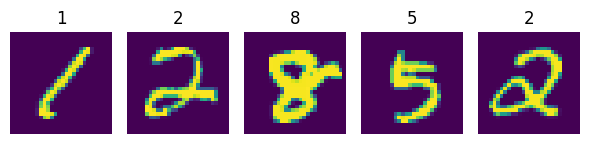

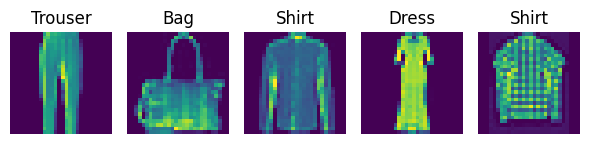

In [4]:
# Display sample images from MNIST Digits
images, labels = next(iter(mnist_digits_loader))
show_images(images[:10], titles=[str(label.item()) for label in labels[:10]])
# Display sample images from MNIST Fashion
fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
images, labels = next(iter(mnist_fashion_loader))
show_images(images[:10], titles=[fashion_labels[label.item()] for label in labels[:10]])

In [5]:
# Print dataset information
print(f"MNIST Digits Dataset Size: {len(mnist_digits)}")
print(f"MNIST Fashion Dataset Size: {len(mnist_fashion)}")
print(" ")
print(f"Number of classes in both datasets: {len(mnist_digits.classes)}")
print("MNIST Digits Labels:", list(range(10)))
print("Fashion MNIST Labels:", fashion_labels)

MNIST Digits Dataset Size: 60000
MNIST Fashion Dataset Size: 60000
 
Number of classes in both datasets: 10
MNIST Digits Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Fashion MNIST Labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Part 2 - GANs

In [6]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Initial layer
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            # Hidden layers
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            # Output layer
            nn.Linear(1024, 784),  # 28x28 = 784
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input layer
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Hidden layers
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Output layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(-1, 784)
        return self.model(img_flat)

In [8]:
# Training function
def train_gan(generator, discriminator, dataloader, num_epochs=50, latent_dim=100, device='cuda' if torch.cuda.is_available() else 'cpu'):

    # Initialize optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Lists to store losses
    g_losses = []
    d_losses = []

    generator.to(device)
    discriminator.to(device)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)

            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            g_optimizer.step()

            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        # Save generated images
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                fake_images = generator(torch.randn(10, latent_dim).to(device)).cpu()
                show_images(fake_images, num_images=10)

    return g_losses, d_losses

Epoch [0/100] Batch [0/938] d_loss: 1.3797 g_loss: 0.7178
Epoch [0/100] Batch [100/938] d_loss: 1.1621 g_loss: 0.8272
Epoch [0/100] Batch [200/938] d_loss: 1.0839 g_loss: 1.2459
Epoch [0/100] Batch [300/938] d_loss: 1.1732 g_loss: 3.2967
Epoch [0/100] Batch [400/938] d_loss: 0.5190 g_loss: 4.0109
Epoch [0/100] Batch [500/938] d_loss: 0.4662 g_loss: 3.9392
Epoch [0/100] Batch [600/938] d_loss: 0.6164 g_loss: 2.3458
Epoch [0/100] Batch [700/938] d_loss: 0.6665 g_loss: 2.6716
Epoch [0/100] Batch [800/938] d_loss: 0.5966 g_loss: 2.6635
Epoch [0/100] Batch [900/938] d_loss: 0.5223 g_loss: 3.4617
Epoch [1/100] Batch [0/938] d_loss: 0.6568 g_loss: 3.5482
Epoch [1/100] Batch [100/938] d_loss: 0.4469 g_loss: 2.2139
Epoch [1/100] Batch [200/938] d_loss: 0.4982 g_loss: 2.4779
Epoch [1/100] Batch [300/938] d_loss: 0.8188 g_loss: 3.9058
Epoch [1/100] Batch [400/938] d_loss: 0.5533 g_loss: 4.0467
Epoch [1/100] Batch [500/938] d_loss: 0.6827 g_loss: 4.1790
Epoch [1/100] Batch [600/938] d_loss: 0.3978

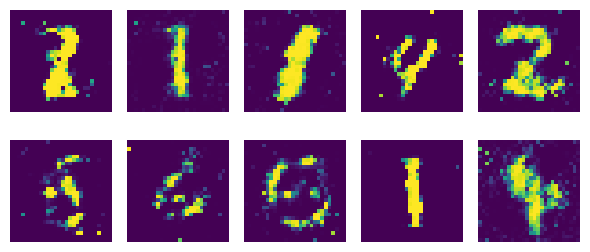

Epoch [10/100] Batch [0/938] d_loss: 1.0280 g_loss: 1.1951
Epoch [10/100] Batch [100/938] d_loss: 1.0355 g_loss: 1.3763
Epoch [10/100] Batch [200/938] d_loss: 1.1056 g_loss: 1.2029
Epoch [10/100] Batch [300/938] d_loss: 0.9081 g_loss: 1.2851
Epoch [10/100] Batch [400/938] d_loss: 1.0846 g_loss: 1.2703
Epoch [10/100] Batch [500/938] d_loss: 1.2089 g_loss: 1.3778
Epoch [10/100] Batch [600/938] d_loss: 1.0661 g_loss: 1.0288
Epoch [10/100] Batch [700/938] d_loss: 1.2053 g_loss: 1.1037
Epoch [10/100] Batch [800/938] d_loss: 1.1384 g_loss: 1.3407
Epoch [10/100] Batch [900/938] d_loss: 1.0684 g_loss: 1.0265
Epoch [11/100] Batch [0/938] d_loss: 1.1195 g_loss: 0.9211
Epoch [11/100] Batch [100/938] d_loss: 1.0947 g_loss: 0.9819
Epoch [11/100] Batch [200/938] d_loss: 1.1056 g_loss: 1.6064
Epoch [11/100] Batch [300/938] d_loss: 0.8395 g_loss: 1.3544
Epoch [11/100] Batch [400/938] d_loss: 0.9817 g_loss: 1.1303
Epoch [11/100] Batch [500/938] d_loss: 0.9579 g_loss: 1.5668
Epoch [11/100] Batch [600/93

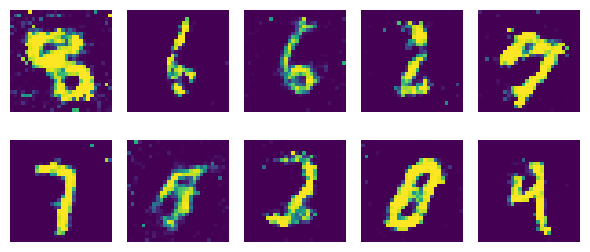

Epoch [20/100] Batch [0/938] d_loss: 1.1697 g_loss: 1.3961
Epoch [20/100] Batch [100/938] d_loss: 1.1626 g_loss: 1.0366
Epoch [20/100] Batch [200/938] d_loss: 1.1941 g_loss: 1.2972
Epoch [20/100] Batch [300/938] d_loss: 1.1289 g_loss: 1.0426
Epoch [20/100] Batch [400/938] d_loss: 1.0688 g_loss: 1.0737
Epoch [20/100] Batch [500/938] d_loss: 1.1242 g_loss: 1.2732
Epoch [20/100] Batch [600/938] d_loss: 1.2350 g_loss: 1.2384
Epoch [20/100] Batch [700/938] d_loss: 0.9981 g_loss: 1.0258
Epoch [20/100] Batch [800/938] d_loss: 1.0551 g_loss: 0.9745
Epoch [20/100] Batch [900/938] d_loss: 1.1681 g_loss: 1.2237
Epoch [21/100] Batch [0/938] d_loss: 1.1974 g_loss: 1.1439
Epoch [21/100] Batch [100/938] d_loss: 1.1750 g_loss: 0.9727
Epoch [21/100] Batch [200/938] d_loss: 1.0768 g_loss: 1.1728
Epoch [21/100] Batch [300/938] d_loss: 1.0145 g_loss: 1.0773
Epoch [21/100] Batch [400/938] d_loss: 1.0255 g_loss: 0.9860
Epoch [21/100] Batch [500/938] d_loss: 1.2119 g_loss: 1.1130
Epoch [21/100] Batch [600/93

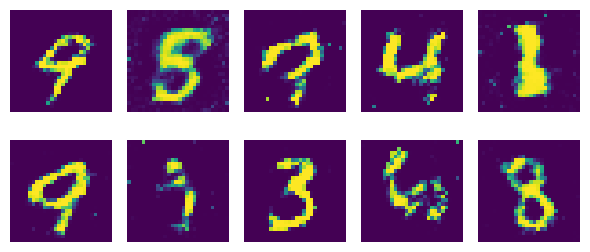

Epoch [30/100] Batch [0/938] d_loss: 0.9966 g_loss: 1.0428
Epoch [30/100] Batch [100/938] d_loss: 1.2466 g_loss: 1.0331
Epoch [30/100] Batch [200/938] d_loss: 1.2441 g_loss: 1.1065
Epoch [30/100] Batch [300/938] d_loss: 1.2196 g_loss: 0.9918
Epoch [30/100] Batch [400/938] d_loss: 1.1733 g_loss: 1.0054
Epoch [30/100] Batch [500/938] d_loss: 1.0246 g_loss: 1.1113
Epoch [30/100] Batch [600/938] d_loss: 1.2319 g_loss: 1.1103
Epoch [30/100] Batch [700/938] d_loss: 1.1163 g_loss: 1.0292
Epoch [30/100] Batch [800/938] d_loss: 1.1472 g_loss: 1.4051
Epoch [30/100] Batch [900/938] d_loss: 1.2077 g_loss: 1.0483
Epoch [31/100] Batch [0/938] d_loss: 1.1853 g_loss: 1.0898
Epoch [31/100] Batch [100/938] d_loss: 1.2465 g_loss: 0.9882
Epoch [31/100] Batch [200/938] d_loss: 1.1612 g_loss: 1.1218
Epoch [31/100] Batch [300/938] d_loss: 1.0806 g_loss: 1.1080
Epoch [31/100] Batch [400/938] d_loss: 1.0963 g_loss: 1.0352
Epoch [31/100] Batch [500/938] d_loss: 1.2542 g_loss: 1.4197
Epoch [31/100] Batch [600/93

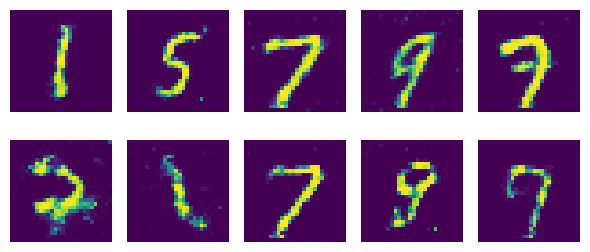

Epoch [40/100] Batch [0/938] d_loss: 1.2034 g_loss: 1.0603
Epoch [40/100] Batch [100/938] d_loss: 1.2581 g_loss: 1.1263
Epoch [40/100] Batch [200/938] d_loss: 1.2143 g_loss: 1.0095
Epoch [40/100] Batch [300/938] d_loss: 1.1376 g_loss: 1.0377
Epoch [40/100] Batch [400/938] d_loss: 1.1246 g_loss: 1.1227
Epoch [40/100] Batch [500/938] d_loss: 1.1320 g_loss: 1.0529
Epoch [40/100] Batch [600/938] d_loss: 1.1565 g_loss: 1.0445
Epoch [40/100] Batch [700/938] d_loss: 1.1920 g_loss: 0.9893
Epoch [40/100] Batch [800/938] d_loss: 1.1790 g_loss: 0.9163
Epoch [40/100] Batch [900/938] d_loss: 1.1909 g_loss: 0.9830
Epoch [41/100] Batch [0/938] d_loss: 1.2101 g_loss: 0.9899
Epoch [41/100] Batch [100/938] d_loss: 1.1681 g_loss: 0.8140
Epoch [41/100] Batch [200/938] d_loss: 1.2604 g_loss: 1.1005
Epoch [41/100] Batch [300/938] d_loss: 1.1280 g_loss: 1.0613
Epoch [41/100] Batch [400/938] d_loss: 1.2060 g_loss: 0.9768
Epoch [41/100] Batch [500/938] d_loss: 1.1207 g_loss: 0.9973
Epoch [41/100] Batch [600/93

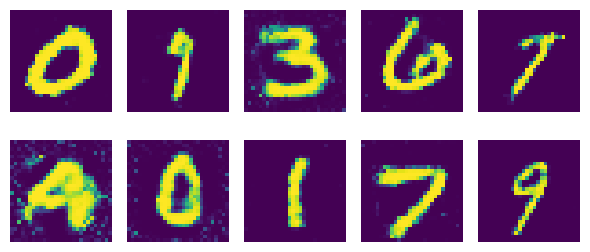

Epoch [50/100] Batch [0/938] d_loss: 1.2239 g_loss: 1.1316
Epoch [50/100] Batch [100/938] d_loss: 1.0618 g_loss: 0.9933
Epoch [50/100] Batch [200/938] d_loss: 1.1967 g_loss: 1.0155
Epoch [50/100] Batch [300/938] d_loss: 1.1622 g_loss: 0.8943
Epoch [50/100] Batch [400/938] d_loss: 1.2382 g_loss: 1.0203
Epoch [50/100] Batch [500/938] d_loss: 1.2323 g_loss: 1.0406
Epoch [50/100] Batch [600/938] d_loss: 1.1795 g_loss: 1.0683
Epoch [50/100] Batch [700/938] d_loss: 1.2492 g_loss: 0.8346
Epoch [50/100] Batch [800/938] d_loss: 1.1900 g_loss: 1.0401
Epoch [50/100] Batch [900/938] d_loss: 1.1996 g_loss: 1.1478
Epoch [51/100] Batch [0/938] d_loss: 1.1938 g_loss: 1.1958
Epoch [51/100] Batch [100/938] d_loss: 1.1533 g_loss: 0.8896
Epoch [51/100] Batch [200/938] d_loss: 1.1794 g_loss: 1.1562
Epoch [51/100] Batch [300/938] d_loss: 1.2632 g_loss: 1.0382
Epoch [51/100] Batch [400/938] d_loss: 1.1232 g_loss: 1.0282
Epoch [51/100] Batch [500/938] d_loss: 1.3035 g_loss: 0.9551
Epoch [51/100] Batch [600/93

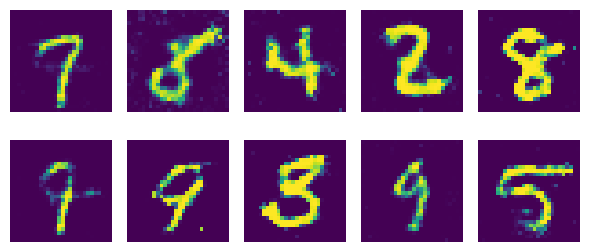

Epoch [60/100] Batch [0/938] d_loss: 1.2438 g_loss: 1.1091
Epoch [60/100] Batch [100/938] d_loss: 1.2717 g_loss: 1.0787
Epoch [60/100] Batch [200/938] d_loss: 1.0707 g_loss: 0.8747
Epoch [60/100] Batch [300/938] d_loss: 1.1465 g_loss: 0.9472
Epoch [60/100] Batch [400/938] d_loss: 1.1850 g_loss: 0.9732
Epoch [60/100] Batch [500/938] d_loss: 1.2128 g_loss: 1.1210
Epoch [60/100] Batch [600/938] d_loss: 1.1187 g_loss: 0.9401
Epoch [60/100] Batch [700/938] d_loss: 1.1481 g_loss: 0.8839
Epoch [60/100] Batch [800/938] d_loss: 1.2068 g_loss: 0.8694
Epoch [60/100] Batch [900/938] d_loss: 1.1843 g_loss: 0.9602
Epoch [61/100] Batch [0/938] d_loss: 1.2341 g_loss: 1.0843
Epoch [61/100] Batch [100/938] d_loss: 1.1832 g_loss: 0.9615
Epoch [61/100] Batch [200/938] d_loss: 1.0915 g_loss: 0.9951
Epoch [61/100] Batch [300/938] d_loss: 1.1196 g_loss: 0.9450
Epoch [61/100] Batch [400/938] d_loss: 1.1904 g_loss: 1.0029
Epoch [61/100] Batch [500/938] d_loss: 1.2298 g_loss: 1.1968
Epoch [61/100] Batch [600/93

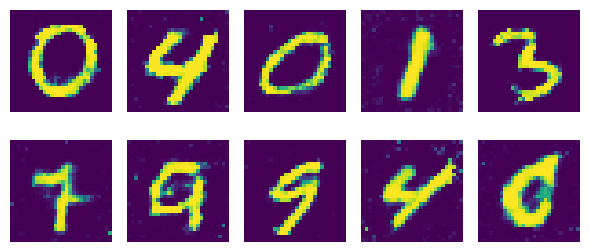

Epoch [70/100] Batch [0/938] d_loss: 1.1388 g_loss: 1.1492
Epoch [70/100] Batch [100/938] d_loss: 1.1778 g_loss: 1.0614
Epoch [70/100] Batch [200/938] d_loss: 1.2438 g_loss: 0.9338
Epoch [70/100] Batch [300/938] d_loss: 1.1965 g_loss: 0.9760
Epoch [70/100] Batch [400/938] d_loss: 1.2352 g_loss: 1.0268
Epoch [70/100] Batch [500/938] d_loss: 1.2628 g_loss: 0.9259
Epoch [70/100] Batch [600/938] d_loss: 1.2332 g_loss: 0.9425
Epoch [70/100] Batch [700/938] d_loss: 1.2517 g_loss: 1.0390
Epoch [70/100] Batch [800/938] d_loss: 1.2020 g_loss: 1.0699
Epoch [70/100] Batch [900/938] d_loss: 1.1585 g_loss: 0.8963
Epoch [71/100] Batch [0/938] d_loss: 1.3051 g_loss: 1.0010
Epoch [71/100] Batch [100/938] d_loss: 1.2681 g_loss: 0.9249
Epoch [71/100] Batch [200/938] d_loss: 1.1918 g_loss: 0.9416
Epoch [71/100] Batch [300/938] d_loss: 1.2733 g_loss: 1.0631
Epoch [71/100] Batch [400/938] d_loss: 1.1966 g_loss: 0.9030
Epoch [71/100] Batch [500/938] d_loss: 1.1578 g_loss: 1.0017
Epoch [71/100] Batch [600/93

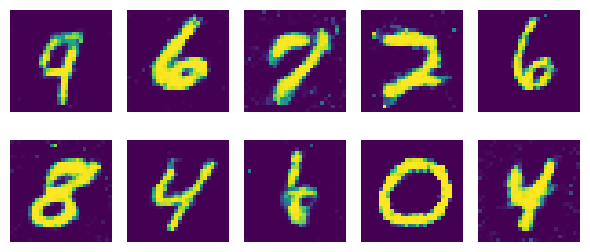

Epoch [80/100] Batch [0/938] d_loss: 1.2390 g_loss: 0.9363
Epoch [80/100] Batch [100/938] d_loss: 1.2708 g_loss: 0.8811
Epoch [80/100] Batch [200/938] d_loss: 1.2650 g_loss: 1.0252
Epoch [80/100] Batch [300/938] d_loss: 1.1738 g_loss: 1.0280
Epoch [80/100] Batch [400/938] d_loss: 1.2651 g_loss: 1.2065
Epoch [80/100] Batch [500/938] d_loss: 1.0447 g_loss: 0.9537
Epoch [80/100] Batch [600/938] d_loss: 1.2194 g_loss: 0.9881
Epoch [80/100] Batch [700/938] d_loss: 1.3143 g_loss: 1.1681
Epoch [80/100] Batch [800/938] d_loss: 1.1735 g_loss: 1.0390
Epoch [80/100] Batch [900/938] d_loss: 1.2242 g_loss: 1.1693
Epoch [81/100] Batch [0/938] d_loss: 1.3557 g_loss: 1.0819
Epoch [81/100] Batch [100/938] d_loss: 1.1767 g_loss: 1.0073
Epoch [81/100] Batch [200/938] d_loss: 1.2522 g_loss: 0.9113
Epoch [81/100] Batch [300/938] d_loss: 1.2067 g_loss: 1.0835
Epoch [81/100] Batch [400/938] d_loss: 1.3298 g_loss: 0.9898
Epoch [81/100] Batch [500/938] d_loss: 1.1433 g_loss: 0.9798
Epoch [81/100] Batch [600/93

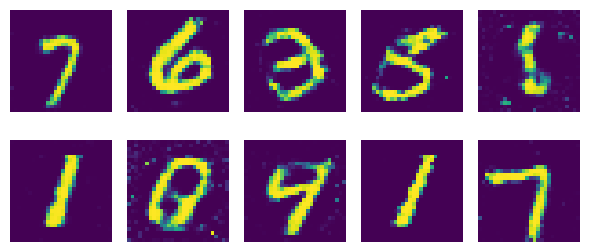

Epoch [90/100] Batch [0/938] d_loss: 1.2771 g_loss: 0.9185
Epoch [90/100] Batch [100/938] d_loss: 1.2263 g_loss: 0.9162
Epoch [90/100] Batch [200/938] d_loss: 1.2101 g_loss: 1.0539
Epoch [90/100] Batch [300/938] d_loss: 1.1165 g_loss: 1.0555
Epoch [90/100] Batch [400/938] d_loss: 1.2570 g_loss: 0.8712
Epoch [90/100] Batch [500/938] d_loss: 1.2097 g_loss: 1.1700
Epoch [90/100] Batch [600/938] d_loss: 1.2434 g_loss: 0.8502
Epoch [90/100] Batch [700/938] d_loss: 1.2658 g_loss: 0.9262
Epoch [90/100] Batch [800/938] d_loss: 1.1612 g_loss: 0.9180
Epoch [90/100] Batch [900/938] d_loss: 1.2073 g_loss: 1.0593
Epoch [91/100] Batch [0/938] d_loss: 1.3487 g_loss: 0.9555
Epoch [91/100] Batch [100/938] d_loss: 1.1792 g_loss: 1.0458
Epoch [91/100] Batch [200/938] d_loss: 1.1918 g_loss: 0.8700
Epoch [91/100] Batch [300/938] d_loss: 1.3562 g_loss: 1.0432
Epoch [91/100] Batch [400/938] d_loss: 1.1603 g_loss: 0.9220
Epoch [91/100] Batch [500/938] d_loss: 1.2182 g_loss: 1.0686
Epoch [91/100] Batch [600/93

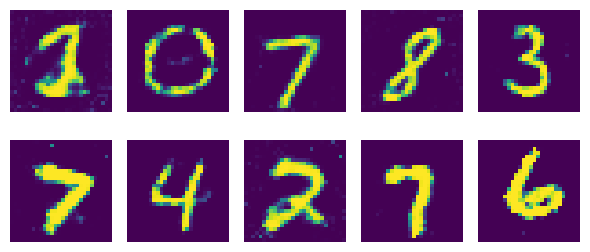

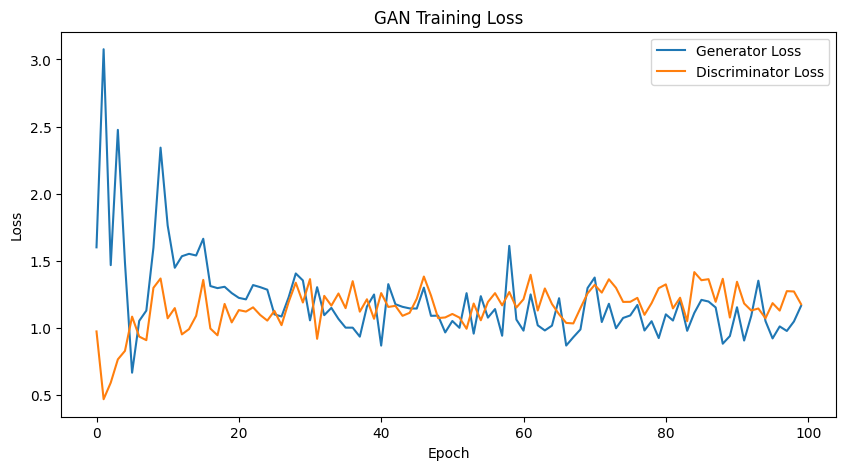

In [9]:
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

# Train GAN
g_losses, d_losses = train_gan(generator, discriminator, mnist_digits_loader, num_epochs=100)

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Loss')
plt.show()

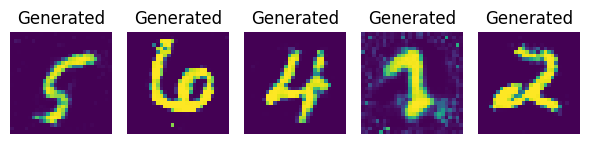

Epoch [0/50] Batch [0/93] d_loss: 1.4165 g_loss: 0.6713
Epoch [1/50] Batch [0/93] d_loss: 1.0184 g_loss: 0.8807
Epoch [2/50] Batch [0/93] d_loss: 0.2704 g_loss: 2.4474
Epoch [3/50] Batch [0/93] d_loss: 0.8285 g_loss: 2.1138
Epoch [4/50] Batch [0/93] d_loss: 0.9960 g_loss: 1.5918
Epoch [5/50] Batch [0/93] d_loss: 0.8425 g_loss: 2.9269
Epoch [6/50] Batch [0/93] d_loss: 0.3444 g_loss: 3.9162
Epoch [7/50] Batch [0/93] d_loss: 0.7997 g_loss: 3.9954
Epoch [8/50] Batch [0/93] d_loss: 0.7161 g_loss: 1.6583
Epoch [9/50] Batch [0/93] d_loss: 1.3890 g_loss: 6.2353


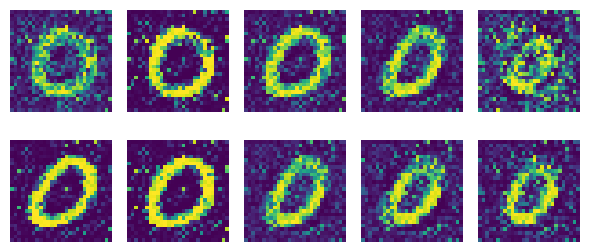

Epoch [10/50] Batch [0/93] d_loss: 1.5245 g_loss: 0.3135
Epoch [11/50] Batch [0/93] d_loss: 0.5814 g_loss: 2.7417
Epoch [12/50] Batch [0/93] d_loss: 0.9908 g_loss: 2.3262
Epoch [13/50] Batch [0/93] d_loss: 0.5259 g_loss: 3.2501
Epoch [14/50] Batch [0/93] d_loss: 0.6038 g_loss: 1.6808
Epoch [15/50] Batch [0/93] d_loss: 0.7571 g_loss: 1.5810
Epoch [16/50] Batch [0/93] d_loss: 0.3153 g_loss: 2.2852
Epoch [17/50] Batch [0/93] d_loss: 0.6027 g_loss: 3.2058
Epoch [18/50] Batch [0/93] d_loss: 0.9476 g_loss: 0.9867
Epoch [19/50] Batch [0/93] d_loss: 1.0235 g_loss: 4.4098


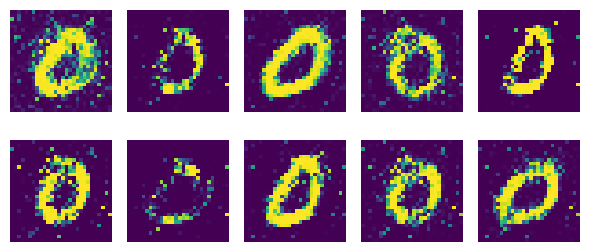

Epoch [20/50] Batch [0/93] d_loss: 0.4795 g_loss: 2.4525
Epoch [21/50] Batch [0/93] d_loss: 0.9006 g_loss: 2.5893
Epoch [22/50] Batch [0/93] d_loss: 0.9006 g_loss: 1.1662
Epoch [23/50] Batch [0/93] d_loss: 0.5594 g_loss: 2.1418
Epoch [24/50] Batch [0/93] d_loss: 0.9928 g_loss: 2.7290
Epoch [25/50] Batch [0/93] d_loss: 0.9035 g_loss: 1.2947
Epoch [26/50] Batch [0/93] d_loss: 0.8469 g_loss: 1.4918
Epoch [27/50] Batch [0/93] d_loss: 0.7408 g_loss: 1.8430
Epoch [28/50] Batch [0/93] d_loss: 0.6821 g_loss: 2.0802
Epoch [29/50] Batch [0/93] d_loss: 1.0578 g_loss: 1.2643


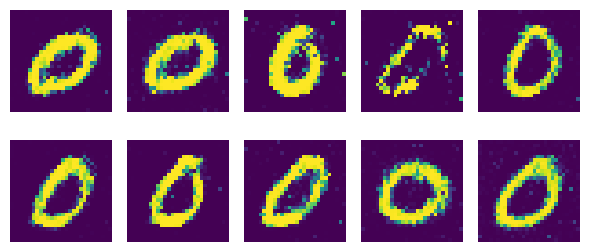

Epoch [30/50] Batch [0/93] d_loss: 0.8309 g_loss: 1.4859
Epoch [31/50] Batch [0/93] d_loss: 0.8662 g_loss: 1.6213
Epoch [32/50] Batch [0/93] d_loss: 1.0375 g_loss: 1.4827
Epoch [33/50] Batch [0/93] d_loss: 1.1495 g_loss: 1.1847
Epoch [34/50] Batch [0/93] d_loss: 1.0774 g_loss: 1.4083
Epoch [35/50] Batch [0/93] d_loss: 1.2809 g_loss: 1.4669
Epoch [36/50] Batch [0/93] d_loss: 1.2751 g_loss: 2.0002
Epoch [37/50] Batch [0/93] d_loss: 1.1294 g_loss: 1.3286
Epoch [38/50] Batch [0/93] d_loss: 1.1647 g_loss: 1.3105
Epoch [39/50] Batch [0/93] d_loss: 1.0932 g_loss: 1.0722


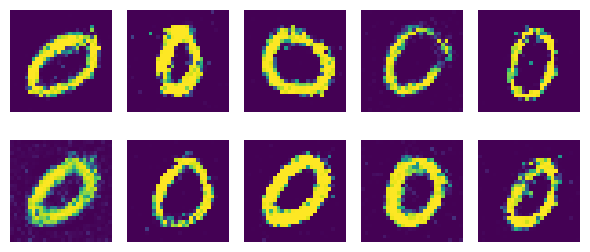

Epoch [40/50] Batch [0/93] d_loss: 1.1025 g_loss: 1.5519
Epoch [41/50] Batch [0/93] d_loss: 1.2492 g_loss: 0.9025
Epoch [42/50] Batch [0/93] d_loss: 1.3748 g_loss: 0.9087
Epoch [43/50] Batch [0/93] d_loss: 1.2222 g_loss: 0.8255
Epoch [44/50] Batch [0/93] d_loss: 1.1582 g_loss: 0.8612
Epoch [45/50] Batch [0/93] d_loss: 1.1478 g_loss: 1.1190
Epoch [46/50] Batch [0/93] d_loss: 0.9868 g_loss: 1.3777
Epoch [47/50] Batch [0/93] d_loss: 1.2001 g_loss: 1.0236
Epoch [48/50] Batch [0/93] d_loss: 1.2506 g_loss: 1.0362
Epoch [49/50] Batch [0/93] d_loss: 1.2467 g_loss: 0.8919


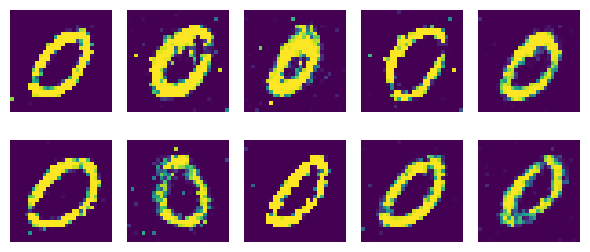

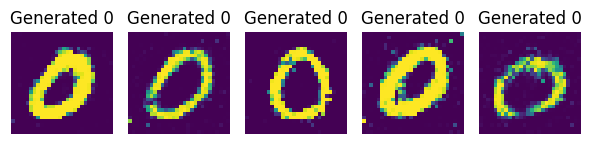

In [17]:
with torch.no_grad():
    z = torch.randn(10, latent_dim).to('cuda')
    generated_images = generator(z).cpu()
    show_images(generated_images, num_images=5, titles=['Generated']*5)

digit_dataset = [(img, label) for img, label in mnist_digits if label == 0]
digit_loader = torch.utils.data.DataLoader(digit_dataset, batch_size=64, shuffle=True)

generator_digit = Generator(latent_dim)
discriminator_digit = Discriminator()
g_losses_digit, d_losses_digit = train_gan(generator_digit, discriminator_digit, digit_loader, num_epochs=50)

# Generate digit 5 images
with torch.no_grad():
    z = torch.randn(10, latent_dim).to('cuda')
    generated_digit = generator_digit(z).cpu()
    show_images(generated_digit, num_images=5, titles=['Generated 0']*5)

Epoch [0/100] Batch [0/94] d_loss: 1.3755 g_loss: 0.7011
Epoch [1/100] Batch [0/94] d_loss: 0.7862 g_loss: 1.4686
Epoch [2/100] Batch [0/94] d_loss: 1.2747 g_loss: 0.4826
Epoch [3/100] Batch [0/94] d_loss: 0.5722 g_loss: 1.7903
Epoch [4/100] Batch [0/94] d_loss: 0.6531 g_loss: 1.9979
Epoch [5/100] Batch [0/94] d_loss: 0.9039 g_loss: 2.6341
Epoch [6/100] Batch [0/94] d_loss: 0.9743 g_loss: 1.2469
Epoch [7/100] Batch [0/94] d_loss: 1.3130 g_loss: 1.7849
Epoch [8/100] Batch [0/94] d_loss: 0.7979 g_loss: 1.4267
Epoch [9/100] Batch [0/94] d_loss: 0.9579 g_loss: 2.7946


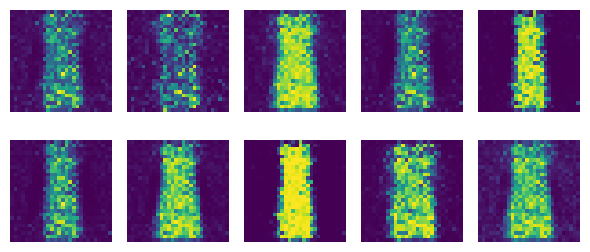

Epoch [10/100] Batch [0/94] d_loss: 1.5005 g_loss: 2.5884
Epoch [11/100] Batch [0/94] d_loss: 0.8648 g_loss: 1.9788
Epoch [12/100] Batch [0/94] d_loss: 0.8528 g_loss: 1.5321
Epoch [13/100] Batch [0/94] d_loss: 1.1748 g_loss: 1.1289
Epoch [14/100] Batch [0/94] d_loss: 1.0066 g_loss: 0.8749
Epoch [15/100] Batch [0/94] d_loss: 0.8910 g_loss: 1.5249
Epoch [16/100] Batch [0/94] d_loss: 1.0790 g_loss: 1.3514
Epoch [17/100] Batch [0/94] d_loss: 1.2010 g_loss: 0.9093
Epoch [18/100] Batch [0/94] d_loss: 1.0075 g_loss: 0.8263
Epoch [19/100] Batch [0/94] d_loss: 1.3752 g_loss: 1.8504


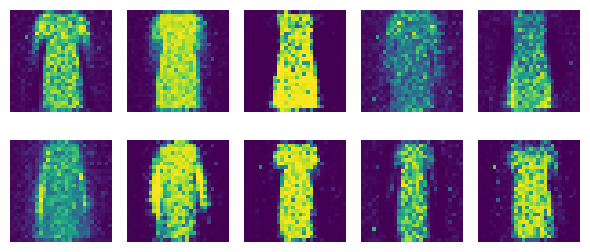

Epoch [20/100] Batch [0/94] d_loss: 1.1806 g_loss: 1.3974
Epoch [21/100] Batch [0/94] d_loss: 0.9788 g_loss: 1.2756
Epoch [22/100] Batch [0/94] d_loss: 1.0934 g_loss: 1.1655
Epoch [23/100] Batch [0/94] d_loss: 0.9521 g_loss: 1.0055
Epoch [24/100] Batch [0/94] d_loss: 1.0990 g_loss: 1.1376
Epoch [25/100] Batch [0/94] d_loss: 1.1766 g_loss: 1.4066
Epoch [26/100] Batch [0/94] d_loss: 1.0861 g_loss: 1.1291
Epoch [27/100] Batch [0/94] d_loss: 1.1628 g_loss: 1.3230
Epoch [28/100] Batch [0/94] d_loss: 1.1419 g_loss: 0.8550
Epoch [29/100] Batch [0/94] d_loss: 1.2230 g_loss: 0.7404


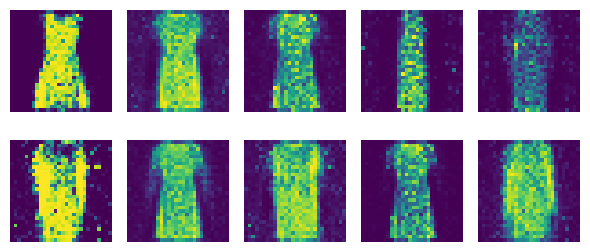

Epoch [30/100] Batch [0/94] d_loss: 1.2183 g_loss: 0.8392
Epoch [31/100] Batch [0/94] d_loss: 1.0880 g_loss: 0.8070
Epoch [32/100] Batch [0/94] d_loss: 1.2801 g_loss: 0.9487
Epoch [33/100] Batch [0/94] d_loss: 1.2660 g_loss: 0.7033
Epoch [34/100] Batch [0/94] d_loss: 1.2979 g_loss: 1.1324
Epoch [35/100] Batch [0/94] d_loss: 1.3903 g_loss: 0.9218
Epoch [36/100] Batch [0/94] d_loss: 1.2608 g_loss: 1.3693
Epoch [37/100] Batch [0/94] d_loss: 1.2569 g_loss: 1.0398
Epoch [38/100] Batch [0/94] d_loss: 1.0794 g_loss: 0.9733
Epoch [39/100] Batch [0/94] d_loss: 1.3778 g_loss: 0.8385


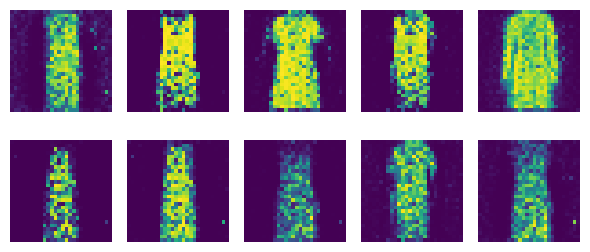

Epoch [40/100] Batch [0/94] d_loss: 1.2681 g_loss: 1.1167
Epoch [41/100] Batch [0/94] d_loss: 1.3461 g_loss: 0.9994
Epoch [42/100] Batch [0/94] d_loss: 1.2507 g_loss: 0.7855
Epoch [43/100] Batch [0/94] d_loss: 1.3066 g_loss: 1.0841
Epoch [44/100] Batch [0/94] d_loss: 1.3078 g_loss: 1.1273
Epoch [45/100] Batch [0/94] d_loss: 1.2746 g_loss: 0.9857
Epoch [46/100] Batch [0/94] d_loss: 1.2633 g_loss: 0.8808
Epoch [47/100] Batch [0/94] d_loss: 1.1844 g_loss: 0.9945
Epoch [48/100] Batch [0/94] d_loss: 1.2071 g_loss: 1.0652
Epoch [49/100] Batch [0/94] d_loss: 1.2200 g_loss: 0.9582


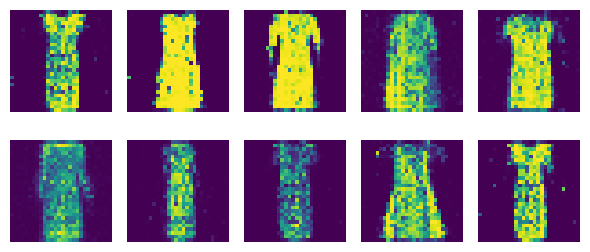

Epoch [50/100] Batch [0/94] d_loss: 1.0949 g_loss: 0.9046
Epoch [51/100] Batch [0/94] d_loss: 1.2897 g_loss: 0.9563
Epoch [52/100] Batch [0/94] d_loss: 1.3658 g_loss: 0.9492
Epoch [53/100] Batch [0/94] d_loss: 1.2014 g_loss: 0.8243
Epoch [54/100] Batch [0/94] d_loss: 1.3709 g_loss: 0.9050
Epoch [55/100] Batch [0/94] d_loss: 1.3308 g_loss: 0.8650
Epoch [56/100] Batch [0/94] d_loss: 1.2489 g_loss: 0.9405
Epoch [57/100] Batch [0/94] d_loss: 1.2971 g_loss: 0.7796
Epoch [58/100] Batch [0/94] d_loss: 1.3499 g_loss: 1.0854
Epoch [59/100] Batch [0/94] d_loss: 1.3109 g_loss: 0.8080


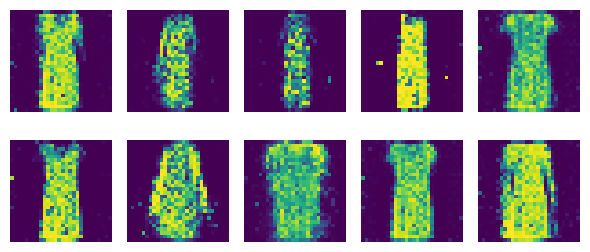

Epoch [60/100] Batch [0/94] d_loss: 1.3035 g_loss: 1.0461
Epoch [61/100] Batch [0/94] d_loss: 1.2962 g_loss: 0.7481
Epoch [62/100] Batch [0/94] d_loss: 1.2234 g_loss: 0.8969
Epoch [63/100] Batch [0/94] d_loss: 1.2599 g_loss: 0.8594
Epoch [64/100] Batch [0/94] d_loss: 1.2987 g_loss: 0.7862
Epoch [65/100] Batch [0/94] d_loss: 1.3234 g_loss: 0.9723
Epoch [66/100] Batch [0/94] d_loss: 1.2752 g_loss: 0.9431
Epoch [67/100] Batch [0/94] d_loss: 1.2861 g_loss: 0.9853
Epoch [68/100] Batch [0/94] d_loss: 1.2840 g_loss: 0.8471
Epoch [69/100] Batch [0/94] d_loss: 1.3441 g_loss: 0.8000


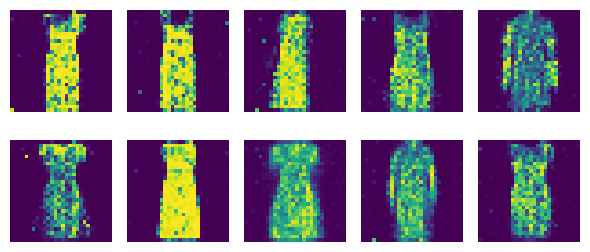

Epoch [70/100] Batch [0/94] d_loss: 1.2339 g_loss: 0.8040
Epoch [71/100] Batch [0/94] d_loss: 1.2456 g_loss: 0.7432
Epoch [72/100] Batch [0/94] d_loss: 1.3495 g_loss: 0.8713
Epoch [73/100] Batch [0/94] d_loss: 1.2899 g_loss: 0.8556
Epoch [74/100] Batch [0/94] d_loss: 1.3607 g_loss: 0.9169
Epoch [75/100] Batch [0/94] d_loss: 1.3610 g_loss: 0.7525
Epoch [76/100] Batch [0/94] d_loss: 1.2936 g_loss: 0.8241
Epoch [77/100] Batch [0/94] d_loss: 1.3227 g_loss: 0.7891
Epoch [78/100] Batch [0/94] d_loss: 1.2359 g_loss: 0.7967
Epoch [79/100] Batch [0/94] d_loss: 1.3431 g_loss: 0.8411


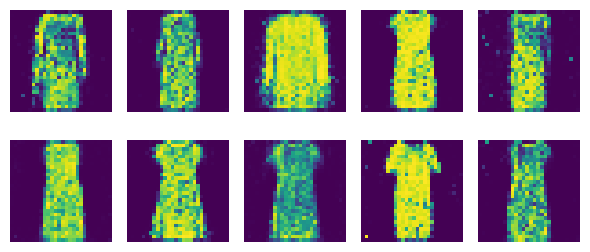

Epoch [80/100] Batch [0/94] d_loss: 1.3148 g_loss: 0.9088
Epoch [81/100] Batch [0/94] d_loss: 1.2872 g_loss: 1.0094
Epoch [82/100] Batch [0/94] d_loss: 1.3112 g_loss: 0.8638
Epoch [83/100] Batch [0/94] d_loss: 1.3077 g_loss: 0.7925
Epoch [84/100] Batch [0/94] d_loss: 1.2435 g_loss: 0.7996
Epoch [85/100] Batch [0/94] d_loss: 1.4258 g_loss: 0.7552
Epoch [86/100] Batch [0/94] d_loss: 1.3745 g_loss: 0.8675
Epoch [87/100] Batch [0/94] d_loss: 1.3025 g_loss: 0.7164
Epoch [88/100] Batch [0/94] d_loss: 1.2969 g_loss: 0.7743
Epoch [89/100] Batch [0/94] d_loss: 1.2905 g_loss: 0.8313


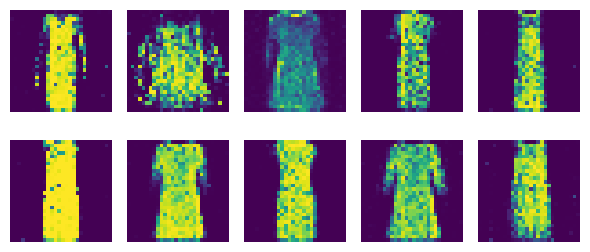

Epoch [90/100] Batch [0/94] d_loss: 1.3482 g_loss: 0.8328
Epoch [91/100] Batch [0/94] d_loss: 1.3827 g_loss: 0.7553
Epoch [92/100] Batch [0/94] d_loss: 1.2451 g_loss: 0.8127
Epoch [93/100] Batch [0/94] d_loss: 1.3906 g_loss: 0.7403
Epoch [94/100] Batch [0/94] d_loss: 1.2979 g_loss: 0.7219
Epoch [95/100] Batch [0/94] d_loss: 1.3390 g_loss: 0.8765
Epoch [96/100] Batch [0/94] d_loss: 1.3231 g_loss: 0.7919
Epoch [97/100] Batch [0/94] d_loss: 1.3740 g_loss: 0.7709
Epoch [98/100] Batch [0/94] d_loss: 1.2604 g_loss: 0.7943
Epoch [99/100] Batch [0/94] d_loss: 1.3894 g_loss: 0.8221


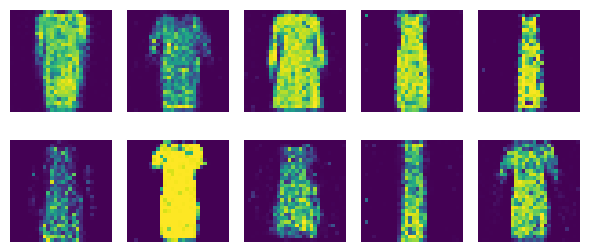

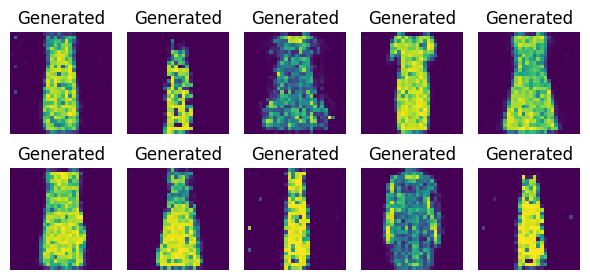

In [21]:
# Train GAN for Fashion MNIST (shoes)
shoe_dataset = [(img, label) for img, label in mnist_fashion if label == 3]
shoe_loader = torch.utils.data.DataLoader(shoe_dataset, batch_size=64, shuffle=True)

# Initialize new GAN for shoes
generator_shoes = Generator(latent_dim)
discriminator_shoes = Discriminator()

# Train GAN on shoes
g_losses_shoes, d_losses_shoes = train_gan(generator_shoes, discriminator_shoes,shoe_loader, num_epochs=100)

# Generate shoe images
with torch.no_grad():
    z = torch.randn(10, latent_dim).to('cuda')
    generated_shoes = generator_shoes(z).cpu()
    show_images(generated_shoes, num_images=10, titles=['Generated']*10)

# Part 3 - VAE

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [35]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [36]:
# Define the VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: Conv2d -> ReLU
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)   # Mean vector
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)  # Log variance vector

        # Decoder: ConvTranspose2d -> ReLU
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output pixels in range (0,1)
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        x = self.decoder_input(z).view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar):
    # BCE Loss for reconstruction
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + kl_div

vae = VAE(latent_dim=2).to('cuda')
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [38]:
num_epochs = 35

vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to('cuda')

        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1, Loss: 153.0686
Epoch 2, Loss: 152.7014
Epoch 3, Loss: 152.4767
Epoch 4, Loss: 152.1712
Epoch 5, Loss: 151.9243
Epoch 6, Loss: 151.7102
Epoch 7, Loss: 151.5774
Epoch 8, Loss: 151.4105
Epoch 9, Loss: 151.1977
Epoch 10, Loss: 151.0842
Epoch 11, Loss: 150.9069
Epoch 12, Loss: 150.7544
Epoch 13, Loss: 150.6198
Epoch 14, Loss: 150.5593
Epoch 15, Loss: 150.3724
Epoch 16, Loss: 150.2929
Epoch 17, Loss: 150.1776
Epoch 18, Loss: 150.1072
Epoch 19, Loss: 150.0685
Epoch 20, Loss: 149.9392
Epoch 21, Loss: 149.8266
Epoch 22, Loss: 149.7818
Epoch 23, Loss: 149.6598
Epoch 24, Loss: 149.6082
Epoch 25, Loss: 149.5145
Epoch 26, Loss: 149.4538
Epoch 27, Loss: 149.3994
Epoch 28, Loss: 149.3789
Epoch 29, Loss: 149.2724
Epoch 30, Loss: 149.2124
Epoch 31, Loss: 149.1605
Epoch 32, Loss: 149.0978
Epoch 33, Loss: 149.0449
Epoch 34, Loss: 148.9589
Epoch 35, Loss: 148.9673


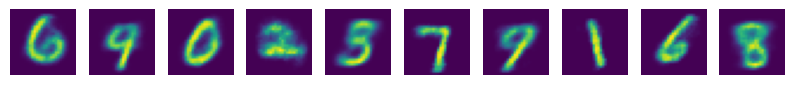

In [40]:
def generate_images(num_samples=10):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 2).to('cuda')  # Sample random latent vectors
        generated_images = vae.decode(z).cpu().view(-1, 28, 28)

    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    for i in range(num_samples):
        axes[i].imshow(generated_images[i])
        axes[i].axis('off')
    plt.show()

generate_images(10)


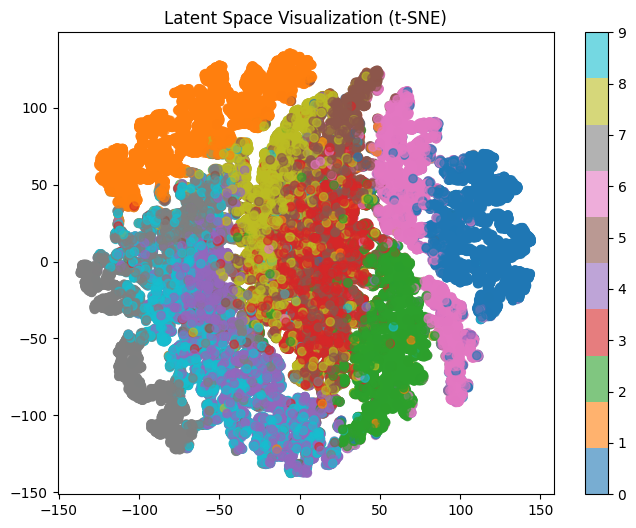

In [41]:
from sklearn.manifold import TSNE
import numpy as np

vae.eval()
latent_vectors, labels = [], []

with torch.no_grad():
    for data, target in train_loader:
        data = data.to('cuda')
        mu, _ = vae.encode(data)
        latent_vectors.append(mu.cpu().numpy())
        labels.extend(target.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title("Latent Space Visualization (t-SNE)")
plt.show()


# Part 4 - Analysis

Written in the report 